## Importação bibliotecas

In [1]:
import os
os.environ['TF_GPU_THREAD_COUNT'] = '5'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
import time
import numpy as np
from joblib import Parallel, delayed
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import math
import setuptools.dist
from collections import Counter
from skimage.transform import resize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import itertools
import seaborn as sns
import tensorflow.python.keras.backend as K
import tsaug as ts
from scipy.ndimage import gaussian_filter
from finta import TA

## Lendo o arquivo de entrada e transformando pra dataframe


In [3]:
file = open('../data/MyoArmband_data.pickle', 'rb')
MyoArm_data = pickle.load(file)
file.close()

In [4]:
def kaufman_adaptive_moving_average(prices, n=10, fast_period=2, slow_period=30):
    """
    Calcula a Kaufman Adaptive Moving Average (KAMA).
    
    Args:
        prices (array-like): Lista de preços (fechamento, por exemplo).
        n (int): Período para calcular a taxa de eficiência (ER).
        fast_period (int): Período rápido para SC rápida.
        slow_period (int): Período lento para SC lenta.
        
    Returns:
        np.ndarray: Valores da KAMA.
    """
    prices = np.array(prices)
    kama = np.zeros_like(prices)
    
    # Constantes de suavização rápida e lenta
    sc_fast = 2 / (fast_period + 1)
    sc_slow = 2 / (slow_period + 1)
    
    # Taxa de eficiência (ER)
    change = np.abs(prices[n:] - prices[:-n])  # Mudança Absoluta
    volatility = np.array([np.sum(np.abs(prices[i+1:i+n+1] - prices[i:i+n])) for i in range(len(prices) - n)])
    efficiency_ratio = np.zeros_like(prices)
    efficiency_ratio[n:] = change / (volatility + 1e-10)  # Evitar divisão por zero
    
    # Constante de suavização (SC)
    sc = (efficiency_ratio * (sc_fast - sc_slow) + sc_slow) ** 2
    
    # Inicializa KAMA
    kama[:n] = prices[:n]  # Usar preços iniciais como baseline
    for i in range(n, len(prices)):
        kama[i] = kama[i-1] + sc[i] * (prices[i] - kama[i-1])
    
    return kama


In [6]:
MyoArm_data = None

In [4]:
#Já engloba todas as pessoas
n = len(MyoArm_data.values())

df = pd.DataFrame()

S1_emg = MyoArm_data['S1']['emg']
S1_label = MyoArm_data['S1']['label']

emg_data = np.array(S1_emg)
labels= np.array(S1_label)

for i in range(1, n):
  key = f"S{i+1}"
  data = MyoArm_data[key]
  #data['emg'] = kaufman_adaptive_moving_average(data['emg'], n=100, fast_period=2, slow_period=500)
  emg_data = np.concatenate((emg_data, data['emg']), axis=0)
  labels = np.concatenate((labels, data['label']), axis=0)


pd.set_option('display.max_colwidth', 50)
df = pd.DataFrame({
  'emg': list(emg_data),
  'label': list(labels),
})
df = df.explode('label')

In [ ]:
#Carregando uma única pessoa
other_person = pd.DataFrame({
  'emg': list(MyoArm_data['S10']['emg']),
  'label': list(MyoArm_data['S10']['label']),
})
other_person = other_person.explode('label')
gestures_list = [1, 13, 14, 17, 18, 19, 34]
resized_new = other_person[other_person['label'].isin(gestures_list)]
new_emg_df = pd.DataFrame(resized_new['emg'].tolist(), index=resized_new.index)
new_emg_df.columns = [f'emg_{i+1}' for i in range(new_emg_df.shape[1])]
new_emg_df = pd.concat([new_emg_df, resized_new['label']], axis=1)
new_emg_df['label'] = new_emg_df['label'].astype(int)

In [6]:
#Calculando o melhor sigma para o filtro gaussiano

best_sigma = 1
best_accuracy = 0

for sigma in range(1,15):
    n = len(MyoArm_data.values())
    
    df = pd.DataFrame()
    
    S1_emg = MyoArm_data['S1']['emg']
    S1_label = MyoArm_data['S1']['label']
    
    emg_data = np.array(S1_emg)
    labels= np.array(S1_label)

    for i in range(1, n):
      key = f"S{i+1}"
      data = MyoArm_data[key]
      emg_data = np.concatenate((emg_data, data['emg']), axis=0)
      labels = np.concatenate((labels, data['label']), axis=0)
    
    emg_data = gaussian_filter(emg_data, sigma=sigma)
    
    df = pd.DataFrame({
  'emg': list(emg_data),
  'label': list(labels),
    })
    df = df.explode('label')
    gestures_list = [1, 13, 14, 17, 18, 19, 34]
    resized_df = df[df['label'].isin(gestures_list)]
    emg_df = pd.DataFrame(resized_df['emg'].tolist(), index=resized_df.index)
    emg_df.columns = [f'emg_{i+1}' for i in range(emg_df.shape[1])]
    emg_df = pd.concat([emg_df, resized_df['label']], axis=1)
    emg_df['label'] = emg_df['label'].astype(int)

    features_df = make_ftr()
    
    X = features_df.drop('label', axis=1)
    y = features_df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    #print(classification_report(y_test, y_pred))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma

    print(f"Best_sigma: {best_sigma}\nBest_accuracy: {best_accuracy}")

Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338
Best_sigma: 1
Best_accuracy: 0.9396189062113338


In [5]:
#Melhores parâmetros para o filtro Time-Warp(Calculando um por vez)

best_n_speed = 1
best_accuracy = 0
n_speed = 1.05
for n_sp in range(2,15):
    n = len(MyoArm_data.values())
    
    df = pd.DataFrame()
    
    S1_emg = MyoArm_data['S1']['emg']
    S1_label = MyoArm_data['S1']['label']
    
    emg_data = np.array(S1_emg)
    labels= np.array(S1_label)

    for i in range(1, n):
      key = f"S{i+1}"
      data = MyoArm_data[key]
      emg_data = np.concatenate((emg_data, data['emg']), axis=0)
      labels = np.concatenate((labels, data['label']), axis=0)
    
    augmenter = ts.TimeWarp(n_speed_change=1, max_speed_ratio=n_speed)
    emg_data = augmenter.augment(emg_data)
    n_speed += 0.05
    
    df = pd.DataFrame({
  'emg': list(emg_data),
  'label': list(labels),
    })
    df = df.explode('label')
    gestures_list = [1, 13, 14, 17, 18, 19, 34]
    resized_df = df[df['label'].isin(gestures_list)]
    emg_df = pd.DataFrame(resized_df['emg'].tolist(), index=resized_df.index)
    emg_df.columns = [f'emg_{i+1}' for i in range(emg_df.shape[1])]
    emg_df = pd.concat([emg_df, resized_df['label']], axis=1)
    emg_df['label'] = emg_df['label'].astype(int)

    features_df = make_ftr()
    
    X = features_df.drop('label', axis=1)
    y = features_df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    #print(classification_report(y_test, y_pred))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_speed = n_speed

    print(f"Best_n_speed: {best_n_speed}\nBest_accuracy: {best_accuracy}")

Best_n_speed: 1.1
Best_accuracy: 0.9772333580796833
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204
Best_n_speed: 1.1500000000000001
Best_accuracy: 0.9789656025736204


In [119]:
# pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_colwidth', 50)

In [120]:
#df = pd.DataFrame({
#  'emg': list(emg_data),
#  'label': list(labels),
#})
#df = df.explode('label')
#df.head(5)

,emg,label
0,"[-22.0, -2.0, -16.0, -7.0, -3.0, -1.0, -2.0, -...",0
1,"[5.0, -4.0, -12.0, -3.0, 8.0, 25.0, 1.0, 1.0, ...",0
2,"[-6.0, 1.0, 4.0, -1.0, -9.0, 0.0, -10.0, -3.0,...",0
3,"[15.0, 10.0, 19.0, 9.0, 10.0, 7.0, 2.0, 1.0, -...",0
4,"[-1.0, -16.0, -17.0, 0.0, -2.0, -7.0, 2.0, 0.0...",0


## Selecionando um subconjunto de movimentos

In [4]:
#Gestos originais
gestures_list = [1, 13, 14, 17, 18, 19, 34]
resized_df = df[df['label'].isin(gestures_list)]

In [5]:
#alguns gestos a mais
gestures_list = [1,2,3,4,5,6,7,8,9, 13, 14, 17, 18, 19, 34]
resized_df = df[df['label'].isin(gestures_list)]

In [5]:
#Criando um data frame onde todos os testes de cada usúario estão concatenados em cada exercício específico
emg_df = pd.DataFrame(resized_df['emg'].tolist(), index=resized_df.index)
emg_df.columns = [f'emg_{i+1}' for i in range(emg_df.shape[1])]
emg_df = pd.concat([emg_df, resized_df['label']], axis=1)
emg_df['label'] = emg_df['label'].astype(int)
#emg_df

In [8]:
emg_df

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,emg_11,emg_12,emg_13,emg_14,emg_15,emg_16,label
767,0.0,0.0,-2.0,-2.0,-1.0,1.0,1.0,1.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,1.0,1
768,4.0,0.0,-2.0,-1.0,0.0,-1.0,-2.0,-9.0,-2.0,-2.0,-4.0,1.0,0.0,-1.0,-1.0,-1.0,1
769,-2.0,-1.0,-1.0,1.0,-2.0,-2.0,0.0,0.0,-2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-3.0,1
770,1.0,-1.0,-2.0,-1.0,-1.0,0.0,-2.0,-10.0,-1.0,-2.0,2.0,0.0,-1.0,0.0,-3.0,-4.0,1
771,-3.0,1.0,0.0,-2.0,-2.0,-1.0,-1.0,-1.0,-2.0,-1.0,-3.0,-2.0,-2.0,-3.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123362,-4.0,-4.0,-2.0,-1.0,-1.0,-1.0,-2.0,-5.0,-1.0,-1.0,-1.0,0.0,-2.0,-4.0,-1.0,-2.0,34
6123363,-1.0,-3.0,-4.0,-2.0,-2.0,-1.0,1.0,2.0,2.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-3.0,34
6123364,-2.0,-1.0,-2.0,-1.0,0.0,1.0,0.0,-4.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,34
6123365,-1.0,-2.0,-1.0,-2.0,1.0,-2.0,-1.0,0.0,0.0,-1.0,-2.0,-2.0,-3.0,-2.0,-2.0,-1.0,34


## Extração de features

In [7]:
def _rms(data):
	"""
	Root Mean Square.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: RMS feature.
	"""
	return math.sqrt(np.power(data, 2).sum() / len(data))

def _zc(data):
	"""
	Zero Crossing.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: ZC feature.
	"""
	return len(np.where(np.diff(np.sign(data)))[0])

def _var(data):
	"""
	Variance.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: Variance feature.
	"""
	return np.var(data)

def _mav(data):
	"""
	Mean Absolute Value.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: MAV feature.
	"""
	return np.mean(np.abs(data))

def _sscl(data):
	"""
	Slope Sign Change List.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: SSC feature.
	"""
	diff_signal = np.diff(data)
	sign_changes = np.diff(np.sign(diff_signal))
 
	return np.sum(sign_changes != 0)

def _wl(data):
	"""
	Waveform Length.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: WL feature.
	"""
	return np.sum(np.abs(np.diff(data)))
def _hrm(data):

    mean = np.mean(data)
    return sum([i for i in data if i>abs(mean)])


#### Faltam testes com a ren com os parâmetros ideais
def _ren(data, m=100, tolerance=50):
    n = len(data)
    
    # Verificar se o comprimento dos dados permite a execução
    if n < m:
        return 0
    
    # Cria uma matriz com todos os segmentos de tamanho `m`
    segments = np.array([data[i:i + m] for i in range(n - m + 1)])
    
    # Calcula as diferenças absolutas entre todos os pares de segmentos
    diffs = np.abs(segments[:, np.newaxis] - segments)
    # Verifica se todas as diferenças dentro de cada par são <= tolerance
    matches = np.all(diffs <= tolerance, axis=2)
    
    # Conta as correspondências, subtrai 1 para não contar o próprio segmento
    count = np.sum(matches) - (n - m + 1)
    
    # Calcula o número total de combinações possíveis
    total_combinations = (n - m) * (n - m + 1) / 2
    
    # Calcula a entropia aproximada
    rough_entropy_value = -np.log(count / total_combinations) if count > 0 else 0
    return rough_entropy_value

In [8]:
#ftrs=['rms', 'zc', 'var', 'mav', 'sscl', 'wl', 'hrm']
#ftrs=['ren']
def mk_features(emg_df):
    ftrs = ['rms', 'zc', 'var', 'mav', 'sscl', 'wl', 'hrm']
    n_channels = 16
    
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in ftrs]
    columns.append('label')
    features_df = pd.DataFrame(columns=columns)
    
    #@dask.delayed
    def process(window, n_channels=16):
      row = {}
      label = np.array(window['label'])
      mostCommonLabel = Counter(label).most_common(1)[0][0]
    
      for i in range(n_channels):
        channel_data = window[f'emg_{i+1}']
    
        rms = _rms(channel_data)
        zc = _zc(channel_data)
        var = _var(channel_data)
        mav = _mav(channel_data)
        sscl = _sscl(channel_data)
        wl = _wl(channel_data)
        hrm = _hrm(channel_data)
        #ren = _ren(channel_data)
    
        row[f'rms_{i+1}'] = rms
        row[f'zc_{i+1}'] = zc
        row[f'var_{i+1}'] = var
        row[f'mav_{i+1}'] = mav
        row[f'sscl_{i+1}'] = sscl
        row[f'wl_{i+1}'] = wl
        row[f'hrm_{i+1}'] = hrm
        #row[f'ren_{i+1}'] = ren
    
      row['label'] = mostCommonLabel
      #features_df.loc[len(features_df)] = row
      return row
    
    window_size = 200
    step = 25
    windows = emg_df.rolling(window=window_size, step=step)
    
    #for window in windows:
    #  if len(window) == window_size:
    #    process(window, n_channels=n_channels)
          
    results = Parallel(n_jobs=-1)(delayed(process)(window, n_channels=n_channels) for window in windows if len(window) == window_size)
    #windows = [window for window in emg_df.rolling(window=window_size, step=step) if len(window) == window_size]
    
    # Cria um Dask Bag a partir das janelas para processamento paralelo
    #windows_bag = db.from_sequence(windows, npartitions=4)
    #results_bag = windows_bag.map(lambda window: process(window, n_channels=n_channels))
    
    # Computa todas as janelas processadas e cria o DataFrame final
    #results = results_bag.compute()
    
    return pd.DataFrame(results, columns=columns)

features_df = mk_features(emg_df)
#new_features_df = mk_features(new_emg_df) # Pessoa(s) separadas

In [67]:
pd.set_option('display.max_columns', 24)
# pd.set_option('display.max_columns', None)

In [11]:
features_df.to_csv('.features.csv', index=False)

In [12]:
features_df = pd.read_csv('.features.csv')
#features_df

## Treinamento do modelo e classificação

In [18]:
X = features_df.drop('label', axis=1)
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### ANN com o cálculo de importância de features utilizando permutação

In [21]:
[y_pred[i][np.argmax(p)] for i, p in enumerate(y_pred)]

[1.0,
 1.0,
 0.9974962,
 0.99999,
 1.0,
 0.99999404,
 1.0,
 0.9999975,
 0.99995315,
 0.9999865,
 0.9999999,
 1.0,
 0.999464,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999995,
 0.99990916,
 0.99991155,
 0.64934224,
 0.99998474,
 0.93442917,
 1.0,
 0.9999993,
 1.0,
 0.9981336,
 0.9999949,
 0.9999857,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6037122,
 0.9999995,
 0.9999995,
 1.0,
 1.0,
 0.99998116,
 0.99991024,
 1.0,
 0.9994024,
 1.0,
 1.0,
 1.0,
 0.9973814,
 1.0,
 1.0,
 1.0,
 0.9998118,
 1.0,
 0.6325453,
 1.0,
 0.9105451,
 0.99999213,
 0.9999323,
 0.98081046,
 0.6972242,
 0.9999981,
 0.9927406,
 0.99289286,
 0.99061626,
 0.9274321,
 1.0,
 0.9980136,
 1.0,
 0.90521115,
 0.9999999,
 1.0,
 0.99988246,
 0.9993082,
 0.9999995,
 0.6462153,
 0.99999845,
 0.99998903,
 0.9804484,
 1.0,
 1.0,
 1.0,
 0.9842572,
 0.9999926,
 1.0,
 0.9998393,
 0.99999917,
 1.0,
 0.9999995,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999,
 1.0,
 1.0,
 1.0,
 0.9999919,
 0.9735473,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.83546704,
 0.99839145,
 1.0,
 0.999992,


In [49]:
from tensorflow.keras.optimizers import Adam
y_train_parsed = to_categorical(y_train)
y_test_parsed = to_categorical(y_test)

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_parsed.shape[1], activation='softmax'))
# Compilar o modelo
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)
history = model.fit(
  X_train,
  y_train_parsed,
  epochs=50,
  batch_size=32,
  validation_data=(X_test, y_test_parsed),
  verbose=0
)

other_X = new_features_df.drop('label', axis=1)
other_y = new_features_df['label']
other_y_test = to_categorical(other_y)

other_X = scaler.transform(other_X)
other_y_pred = model.predict(other_X)


y_pred_classes = np.argmax(other_y_pred, axis=1)
y_test_classes = np.argmax(other_y_test, axis=1)


print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

/home/tl/Desktop/code/.nix-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.27688564476885646
              precision    recall  f1-score   support

           1       0.25      0.57      0.35       287
          13       0.41      0.40      0.40       293
          14       0.12      0.02      0.03       293
          17       0.41      0.48      0.44       288
          18       1.00      0.14      0.25       301
          19       0.15      0.34      0.21       302
          34       0.00      0.00      0.00       291

    accuracy                           0.28      2055
   macro avg       0.34      0.28      0.24      2055
weighted avg       0.34      0.28      0.24      2055



/home/tl/Desktop/code/.nix-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9320244184128031
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       817
          13       0.96      0.92      0.94       935
          14       0.91      0.93      0.92       866
          17       0.91      0.95      0.93       860
          18       0.94      0.92      0.93       859
          19       0.90      0.95      0.92       873
          34       0.96      0.91      0.94       851

    accuracy                           0.93      6061
   macro avg       0.93      0.93      0.93      6061
weighted avg       0.93      0.93      0.93      6061

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 

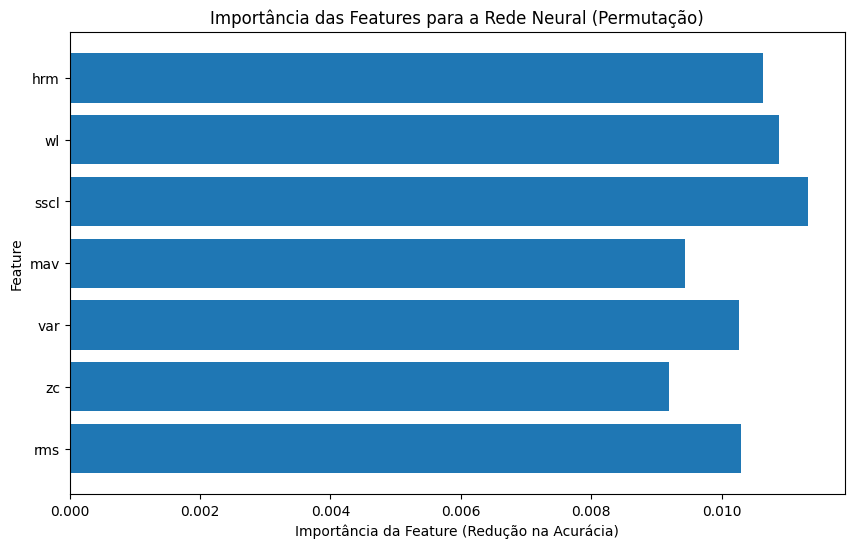

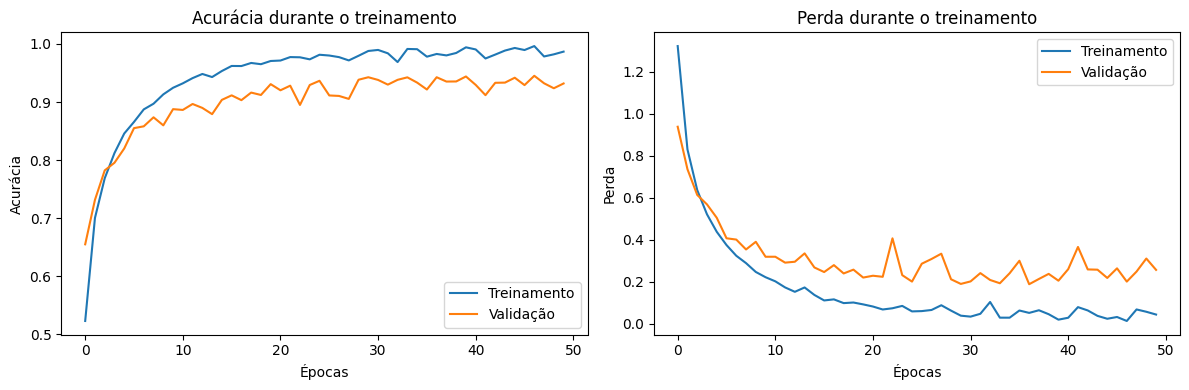

In [39]:
from sklearn.metrics import mean_squared_error
y_train_parsed = to_categorical(y_train)
y_test_parsed = to_categorical(y_test)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_parsed.shape[1], activation='softmax'))
# Compilar o modelo
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
history = model.fit(
  X_train,
  y_train_parsed,
  epochs=50,
  batch_size=32,
  validation_data=(X_test, y_test_parsed),
  verbose=0
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_parsed, axis=1)


print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

def permutation_importance(model, X_test, y_test_classes, baseline_accuracy):
    importances = []

    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])  # Permutar a coluna i
        # Fazer predições com a feature permutada
        y_permuted_pred = model.predict(X_test_permuted)
        y_permuted_classes = np.argmax(y_permuted_pred, axis=1)

        # Calcular a acurácia com a feature permutada
        permuted_accuracy = accuracy_score(y_test_classes, y_permuted_classes)
        importance = baseline_accuracy - permuted_accuracy
        importances.append(importance)
    return importances

# Calcular as importâncias das features
importances = permutation_importance(model, X_test, y_test_classes, baseline_accuracy)

features_mean = [0 for _ in range(int(len(importances)/16))]

for fm in range(len(features_mean)):
    for i in range(fm, len(importances), 16):
        features_mean[fm] += importances[i]
    features_mean[fm] = features_mean[fm]/16

importances = features_mean


feature_names = []

for i in range(0,len(features_mean)):
    name = X.keys()[i].split("_")[0]
    feature_names.append(name)


# Plotar a importância das features
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Importância da Feature (Redução na Acurácia)")
plt.ylabel("Feature")
plt.title("Importância das Features para a Rede Neural (Permutação)")
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

<h1>KNN só com os casos de teste, e logo após tentando prever uma pessoa de fora do conjunto de testes</h1>

In [47]:
X = features_df.drop('label', axis=1)
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

other_X = new_features_df.drop('label', axis=1)
other_y = new_features_df['label']


other_X = scaler.transform(other_X)
other_y_pred = knn.predict(other_X)

print(f'Accuracy(outside test cases): {accuracy_score(other_y, other_y_pred)}')
print(classification_report(other_y, other_y_pred))

Accuracy: 0.8662256523337009
              precision    recall  f1-score   support

           1       0.82      0.93      0.87       805
          13       0.82      0.93      0.87       781
          14       0.87      0.83      0.85       792
          17       0.88      0.87      0.87       755
          18       0.88      0.81      0.84       762
          19       0.88      0.84      0.86       799
          34       0.94      0.85      0.89       748

    accuracy                           0.87      5442
   macro avg       0.87      0.87      0.87      5442
weighted avg       0.87      0.87      0.87      5442

Accuracy(outside test cases): 0.24574209245742093
              precision    recall  f1-score   support

           1       0.18      0.99      0.31       287
          13       0.32      0.23      0.27       293
          14       0.06      0.01      0.02       293
          17       0.60      0.27      0.37       288
          18       1.00      0.20      0.33       301

### KNN

In [40]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.902656327338723
              precision    recall  f1-score   support

           1       0.89      0.94      0.92       817
          13       0.87      0.94      0.90       935
          14       0.90      0.92      0.91       866
          17       0.93      0.90      0.91       860
          18       0.89      0.85      0.87       859
          19       0.90      0.86      0.88       873
          34       0.95      0.92      0.93       851

    accuracy                           0.90      6061
   macro avg       0.90      0.90      0.90      6061
weighted avg       0.90      0.90      0.90      6061



<h1>KNN com uma pessoa de fora</h1>

In [48]:
other_X = new_features_df.drop('label', axis=1)
other_y = new_features_df['label']


other_X = scaler.transform(other_X)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
other_y_pred = knn.predict(other_X)

print(f'Accuracy: {accuracy_score(other_y, other_y_pred)}')
print(classification_report(other_y, other_y_pred))

Accuracy: 0.24574209245742093
              precision    recall  f1-score   support

           1       0.18      0.99      0.31       287
          13       0.32      0.23      0.27       293
          14       0.06      0.01      0.02       293
          17       0.60      0.27      0.37       288
          18       1.00      0.20      0.33       301
          19       0.11      0.01      0.02       302
          34       0.65      0.04      0.07       291

    accuracy                           0.25      2055
   macro avg       0.42      0.25      0.20      2055
weighted avg       0.42      0.25      0.20      2055



### Random Forest

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
feature_names = X.columns

features_mean = [0 for _ in range(int(len(feature_names)/16))]

for fm in range(len(features_mean)):
    for i in range(fm, len(feature_importances), 16):
        features_mean[fm] += feature_importances[i]
    features_mean[fm] = features_mean[fm]/16

importances = features_mean


ft_names = []

for i in range(0,len(features_mean)):
    name = feature_names[i].split("_")[0]
    ft_names.append(name)

feature_names = ft_names

# Ordenar e plotar
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feature_importances.plot(kind='bar')
plt.title('Importância das Características')
plt.show()

Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00         3
          19       1.00      1.00      1.00         3
          34       1.00      1.00      1.00         2

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



NameError: name 'feature_importances' is not defined

### SVM

In [46]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8134125216530562
              precision    recall  f1-score   support

           1       0.80      0.89      0.85       517
          13       0.81      0.85      0.83       630
          14       0.80      0.78      0.79       595
          17       0.84      0.78      0.81       585
          18       0.80      0.76      0.78       561
          19       0.78      0.76      0.77       569
          34       0.86      0.88      0.87       584

    accuracy                           0.81      4041
   macro avg       0.81      0.81      0.81      4041
weighted avg       0.81      0.81      0.81      4041



In [8]:
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [12]:
import gc

class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

## Classificação por combinação de features

In [15]:
# Definição das features e combinações
base_features = ['wl', 'sscl', 'hrm']
#additional_features = ['hrm']
additional_features = ['rms', 'var', 'zc', 'mav']
combinations = [base_features + list(combo) for i in 
                range(len(additional_features)+1) for combo in itertools.combinations(additional_features, i)]

# Configuração dos dados
scaler = StandardScaler()
y = features_df['label']
n_channels = 16
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Configuração da GPU


# Função para treinamento do modelo
def thrd(combination):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    ## LIMIT GPU USAGE
    #config = tf.compat.v1.ConfigProto()  
    #config.gpu_options.allow_growth = True  
    #config.gpu_options.per_process_gpu_memory_fraction = 0.18 
    #K.set_session(tf.compat.v1.Session(config=config))
    
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in combination]
    X = features_df[columns]
    accuracies = []
    
    #best_model = None
    #best_accuracy = 0
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
       
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
       
        y_train_parsed = to_categorical(y_train)
        y_test_parsed = to_categorical(y_test)

        model = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(y_train_parsed.shape[1], activation='softmax')
        ])
    
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
    
            # Treina o modelo
        model.fit(
            X_train,
            y_train_parsed,
            epochs=50,  
            batch_size=32,
            validation_data=(X_test, y_test_parsed),
            verbose=0,
            callbacks=[CustomCallback()]
        )
    
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_parsed, axis=1)
    
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        
        #if accuracy > best_accuracy:
        #    best_model = model
        #    best_accuracy = accuracy
            
        accuracies.append(accuracy)

        #predictions = model.predict(X_test),flatten()
        
    #y_pred = best_model.predict(X_test)
    #y_pred_classes = np.argmax(y_pred, axis=1)
    #y_test_classes = np.argmax(y_test_parsed, axis=1)
    
    #accuracy = accuracy_score(y_test_classes, y_pred_classes)
    #accuracies.append(accuracy)
    print(f'Acurácias para features {combination}: {accuracies}')

    #plot_time_series(y_test_classes, y_pred_classes)
    #plot_residuals(y_test_classes, y_pred)
    #plot_real_vs_pred(y_test_classes, y_pred_classes)
    #plot_error_distribution(y_test_classes, y_pred_classes)
    return accuracies

# Executa o pipeline para cada combinação
def sequential_accuracies():
    start_time = time.time()
    accuracies_plot = []
    #for combination in combinations:
    #   accuracies = thrd(combination)
    #   accuracies_plot.append(accuracies)
    
    accuracies_plot = Parallel(n_jobs=5)(delayed(thrd)(combination) for combination in combinations)  #Caso queira executar em paralelo (n_jobs=-1 para usar todos os cores)
    end_time = time.time()
    print(f"Tempo de execução total: {end_time - start_time}")
    return accuracies_plot

# Executa e armazena as acurácias
accuracies_plot = sequential_accuracies()


2024-11-27 18:54:04.703277: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different 2024-11-27 18:54:04.703276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 18:54:04.713981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Att2024-11-27 18:54:04.713981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
empting to register factory for plugin cuFFT when one has already been reg

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/stepep 
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━

/home/tl/Desktop/code/.nix-venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Acurácias para features ['wl', 'sscl', 'hrm', 'rms', 'var', 'mav']: [0.9321950012373175, 0.9111606038109379, 0.9356594902251918, 0.9220297029702971, 0.933910891089109]
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepe


2024-11-27 19:07:15.152045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 19:07:15.186348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732745235.205907  980460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732745235.210703  980460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 19:07:15.225708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Acurácias para features ['wl', 'sscl', 'hrm', 'rms', 'var', 'zc']: [0.9485275921801535, 0.9304627567433803, 0.961395694135115, 0.9455445544554455, 0.9477722772277227]
Acurácias para features ['wl', 'sscl', 'hrm', 'var', 'zc', 'mav']: [0.9309576837416481, 0.935164563226924, 0.9547141796585004, 0.9507425742574257, 0.9061881188118812]
Acurácias para features ['wl', 'sscl', 'hrm', 'rms', 'zc', 'mav']: [0.9455580301905468, 0.9428359317000743, 0.9467953476862163, 0.9547029702970297, 0.9321782178217822]


I0000 00:00:1732745238.153088  980460 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5716 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1732745239.107463  980574 service.cc:148] XLA service 0x7ffe78008fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732745239.107486  980574 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-11-27 19:07:19.122303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732745239.189489  980574 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732745240.794526  980574 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepe
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepe
Tempo de execução total: 919.4785597324371


In [ ]:
# Definição das features e combinações
base_features = ['rms', 'hrm', 'zc']
#additional_features = ['hrm']
additional_features = ['sscl', 'var', 'mav', 'wl']
combinations = [base_features + list(combo) for i in range(len(additional_features)+1) for combo in itertools.combinations(additional_features, i)]
# Configuração dos dados
scaler = StandardScaler()
y = features_df['label']
n_channels = 16
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Configuração da GPU


# Função para treinamento do modelo
def thrd(combination):
    #gpus = tf.config.list_physical_devices('GPU')
    #if gpus:
    #    tf.config.experimental.set_memory_growth(gpus[0], True)
    ## LIMIT GPU USAGE
    config = tf.compat.v1.ConfigProto()  
    config.gpu_options.allow_growth = True  
    config.gpu_options.per_process_gpu_memory_fraction = 0.20 
    K.set_session(tf.compat.v1.Session(config=config))
    
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in combination]
    X = features_df[columns]
    accuracies = []
    
    best_model = None
    best_accuracy = 0
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
       
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
       
        y_train_parsed = to_categorical(y_train)
        y_test_parsed = to_categorical(y_test)

        
      
        model = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(y_train_parsed.shape[1], activation='softmax')
        ])
    
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
    
            # Treina o modelo
        model.fit(
            X_train,
            y_train_parsed,
            epochs=50,  
            batch_size=32,
            validation_data=(X_test, y_test_parsed),
            verbose=0
        )
    
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_parsed, axis=1)
    
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy
            
        accuracies.append(accuracy)

        #predictions = model.predict(X_test),flatten()
        
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_parsed, axis=1)
    
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    accuracies.append(accuracy)
    print(f'Acurácias para features {combination}: {accuracies}')
    plot_time_series(y_test_classes, y_pred_classes)
    plot_residuals(y_test_classes, y_pred_classes)
    plot_real_vs_pred(y_test_classes, y_pred_classes)
    plot_error_distribution(y_test_classes, y_pred_classes)
    return accuracies

# Executa o pipeline para cada combinação
def sequential_accuracies():
    start_time = time.time()
    accuracies_plot = []
    for combination in combinations:
       accuracies = thrd(combination)
       accuracies_plot.append(accuracies)
    
    #accuracies_plot = Parallel(n_jobs=2)(delayed(thrd)(combination) for combination in combinations)
    end_time = time.time()
    print(f"Tempo de execução total: {end_time - start_time}")
    return accuracies_plot

# Executa e armazena as acurácias
accuracies_plot = sequential_accuracies()


I0000 00:00:1732742198.648028  646893 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6165 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<h1>Gráfico de Séries Temporais</h1>

In [14]:
def plot_time_series(y_test, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Valores Reais", color="blue", marker="o")
    plt.plot(predictions, label="Previsões do Modelo", color="red", marker="x")
    plt.xlabel("Tempo (índice do tempo no conjunto de teste)")
    plt.ylabel("Valor")
    plt.title("Gráfico de Série Temporal: Valores Reais vs Previsões do Modelo")
    plt.legend()
    plt.show()



<h1>Gráfico de Erro Residual</h1>

In [15]:
def plot_residuals(y_test, predictions):

    errors = errors = y_test - predictions
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=errors, color="purple")
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Gráfico de Erro Residual")
    plt.xlabel("Valores Previstos")
    plt.ylabel("Erro Residual")
    plt.show()




<h1>Gráfico de Dispersão (Valores Reais vs. Previstos)</h1>

In [16]:
def plot_real_vs_pred(y_test, predictions):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, color="blue", alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color="red")  # Linha de referência 45 graus
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Previstos")
    plt.title("Gráfico de Dispersão: Valores Reais vs Valores Previstos")
    plt.show()



<h1>Gráfico de Distribuição do Erro</h1>

In [17]:
def plot_error_distributionasd(y_test, predictions):
    errors = [1-predictions[i][yt] for i,yt in enumerate(y_test)]
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, color="blue", bins=30)
    plt.axvline(x=0, color='red', linestyle='--', label='Erro Zero')
    plt.xlabel("Erro (Valor Real - Valor Previsto)")
    plt.ylabel("Frequência")
    plt.title("Distribuição de Erro das Previsões do Modelo")
    plt.legend()
    plt.show()

def plot_error_distribution(y_test, predictions):
    errors = y_test - predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, color="blue", bins=30)
    plt.axvline(x=0, color='red', linestyle='--', label='Erro Zero')
    plt.xlabel("Erro (Valor Real - Valor Previsto)")
    plt.ylabel("Frequência")
    plt.title("Distribuição de Erro das Previsões do Modelo")
    plt.legend()
    plt.show()


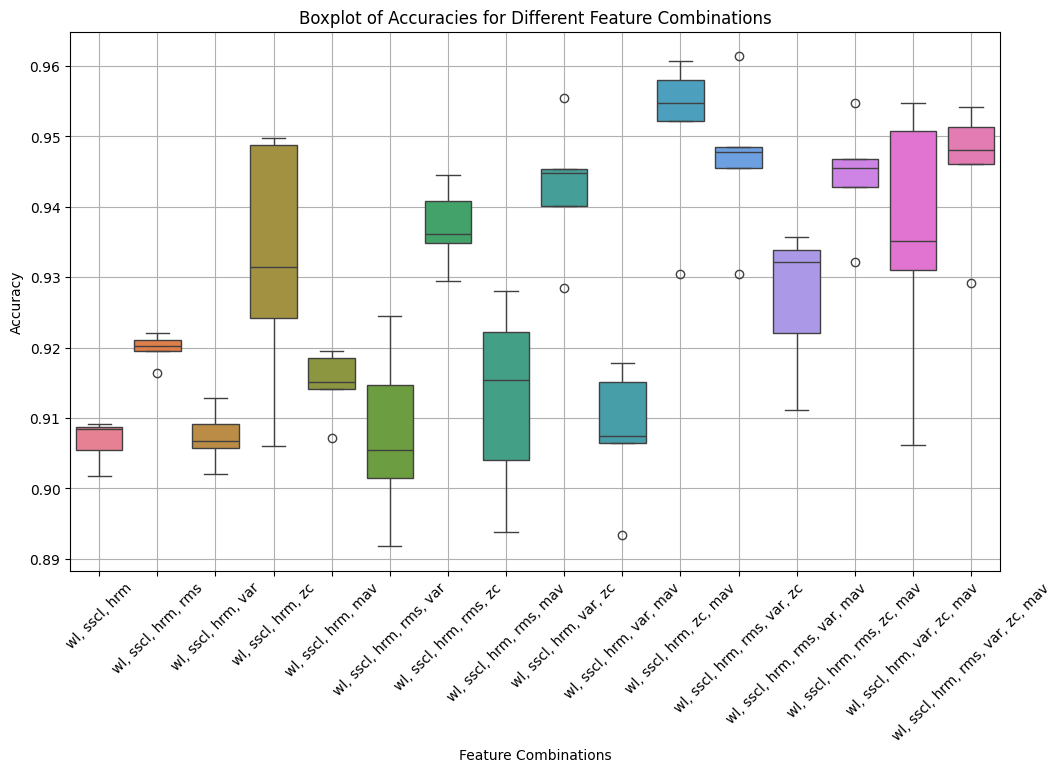

Acurácias para features ['wl', 'sscl', 'hrm', 'rms', 'var', 'zc', 'mav']: [0.9542192526602327, 0.9480326651818857, 0.951249690670626, 0.9292079207920793, 0.946039603960396]


In [16]:
accuracies_df = pd.DataFrame(accuracies_plot).T
accuracies_df.columns = [', '.join(combo) for combo in combinations]

# Plotar gráfico boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=accuracies_df)
plt.xticks(rotation=45)
plt.xlabel('Feature Combinations')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracies for Different Feature Combinations')
plt.grid()
plt.show()